# DICOM Introduction

In [1]:
import os
import numpy as np
from pytomography.io.SPECT import dicom
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.utils import print_collimator_parameters
import matplotlib.pyplot as plt
import pydicom
import shutil


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_c.so.1.8.0
    parallelproj CUDA lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_cuda.so.1.8.0
    


## Part 1: Opening Data

First we specify the required filepaths to open the SPECT scan (`file_NM`) and the CT data files (`files_CT`).

In [2]:
# initialize the `path`` variable below to specify the location of the required data
path = '/disk1/pytomography_tutorial_data/dicom_intro_tutorial/' 
path_CT = os.path.join(path, 'CT')
files_CT = [os.path.join(path_CT, file) for file in os.listdir(path_CT)]
file_NM = os.path.join(path, 'projection_data.dcm')

The metadata for object space and projection space can be obtained from the projection data file using `dicom.get_metadata`

* This contains informaiton such as the voxel size, number of angles, scanner radius, etc.

In [3]:
object_meta, proj_meta = dicom.get_metadata(file_NM, index_peak=0)

We can get the photopeak projection data from the DICOM file provided we know the indices of each of the energy windows. We can obtain that as follows:

In [4]:
print(pydicom.read_file(file_NM).EnergyWindowInformationSequence)

[(0054, 0013)  Energy Window Range Sequence  1 item(s) ---- 
   (0054, 0014) Energy Window Lower Limit           DS: '187.19999694824'
   (0054, 0015) Energy Window Upper Limit           DS: '228.80000305176'
   ---------
(0054, 0018) Energy Window Name                  SH: 'Window Group A'(0054, 0013)  Energy Window Range Sequence  1 item(s) ---- 
   (0054, 0014) Energy Window Lower Limit           DS: '166.39999389648'
   (0054, 0015) Energy Window Upper Limit           DS: '187.19999694824'
   ---------
(0054, 0018) Energy Window Name                  SH: 'Window Group B'(0054, 0013)  Energy Window Range Sequence  1 item(s) ---- 
   (0054, 0014) Energy Window Lower Limit           DS: '228.80000305176'
   (0054, 0015) Energy Window Upper Limit           DS: '249.60000610352'
   ---------
(0054, 0018) Energy Window Name                  SH: 'Window Group C'(0054, 0013)  Energy Window Range Sequence  1 item(s) ---- 
   (0054, 0014) Energy Window Lower Limit           DS: '101.69999694

In this case, we specify `index_peak=0`, so it only returns the projections corresponding to the 187-228 energy window above.

In [5]:
photopeak = dicom.get_projections(file_NM, index_peak=0)
photopeak.shape

torch.Size([96, 128, 128])

The shape of the photopeak is $(N_{angles}, \text{Width}, \text{Height})$.

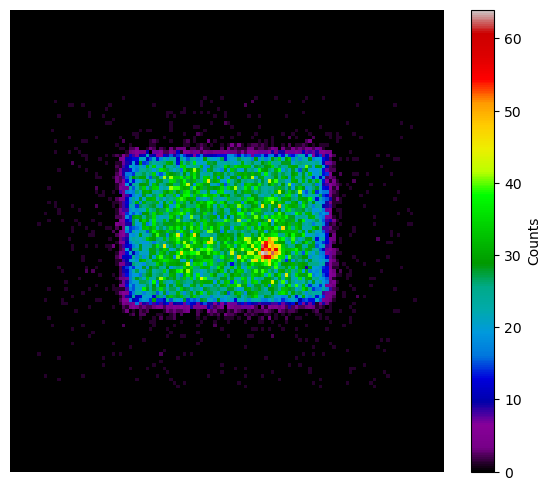

In [6]:
plt.figure(figsize=(7,6))
plt.pcolormesh(photopeak[0].cpu().T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar(label='Counts')

Scatter projections can be estimated using the triple energy window function `dicom_get_scatterTEW`. One needs to specify the index of the peak, and lower/upper energy windows

In [7]:
scatter = dicom.get_energy_window_scatter_estimate(file_NM, index_peak=0, index_lower=1, index_upper=2)

## Part 2: Modeling

### Attenuation Transform

The attenuation transform is used to "correct" for the fact that some photons get atteunated in the patient before they reach the detector. PyTomography has functionality to do attenuation correction provided either (i) an argument `attenuation_map=...` OR (ii) an argument `filepath=...` is provided to the `SPECTAttenuationTransform`.

* `attenuation_map` must be aligned with the SPECT projection data and have units of cm $^{-1}$ .
* `filepath` specifies the directory of some CT scan which will be used for attenuation correction. PyTomography has functionality to align this with the SPECT projections and convert to units of cm $^{-1}$.

In this case, since we're reconstructing DICOM data, it's easier to use `filepath` than to manually align/rescale the CT data

In [8]:
att_transform = SPECTAttenuationTransform(filepath=files_CT)

If we want to view the attenuation map, we need to *configure* the `att_transform` so that (i) the CT data can be aligned with SPECT projection data and (ii) the CT data can be converted to attenuation coefficients.

* *Note*: This is not required if you don't want to view the attenuation map. Later, when the system matrix is built, it automatically configures all the transforms

In [9]:
att_transform.configure(object_meta, proj_meta)
attenuation_map = att_transform.attenuation_map

Given photopeak energy 208.0 keV and CT energy 130 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 208.0 keV SPECT energy, 130 keV CT energy, and scanner model symbiat2


Viewing the attenuation map allows for a consistency check to ensure that it's properly aligned with the projection data

In [10]:
sample_slice = attenuation_map.cpu()[:,70].T

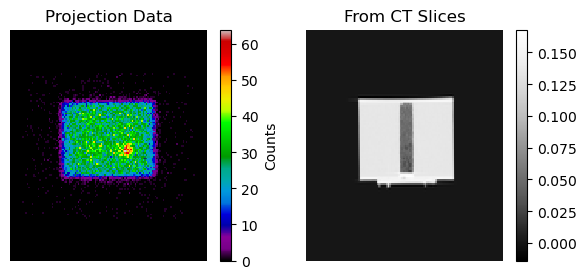

In [11]:
plt.subplots(1,2,figsize=(7,3))
plt.subplot(121)
plt.title('Projection Data')
plt.pcolormesh(photopeak[0].cpu().T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar(label='Counts')
plt.subplot(122)
plt.title('From CT Slices')
plt.pcolormesh(sample_slice, cmap='Greys_r')
plt.axis('off')
plt.colorbar()

### PSF Modeling

PSF modeling requires knowing the parameters of the collimators used for the scan. A list of all supported collimator types can be determined by uncommenting the following line and running it

In [12]:
#print_collimator_parameters()

In our case, we know that this scan was performed on a Siemens Symbia scanner with medium energy collimators and 3/8'' crystals
* There is an option to use intrinsic resolution of the crystals of the scanner (if you know it); this has a minor impact on the reconstruction

In [13]:
collimator_name = 'SY-ME'
energy_kev = 208 #keV
intrinsic_resolution=0.38 #mm
psf_meta = dicom.get_psfmeta_from_scanner_params(
    collimator_name,
    energy_kev,
    intrinsic_resolution=intrinsic_resolution
)
print(psf_meta)

kernel_dimensions = 2D
min_sigmas = 3
sigma_fit_params = [0.03161992134409504, 0.1248503046423388, 0.16137114205472364]



Now we can build our PSF transform required to create the system matrix

In [14]:
psf_transform = SPECTPSFTransform(psf_meta)

## System Matrix

Now that we have the required transforms, we can begin to build the system matrix. It requires:
1. `obj2obj_transforms`. These map from object space to object space. In the case of SPECT imaging, both the attenuation transform and PSF transform correspond to these types of transforms.
2. `proj2proj_transforms`: These map from projection to projection space. Though we have none here, they would be used to model PSF in PET imaging.
3. `object_meta` and `proj_meta`. These are used to initialize the transforms. For example, data from `object_meta` is used to align the attenuation map, and radial position from `proj_meta` is used to get proper blurring parameters for the PSF transform

In [15]:
system_matrix = SPECTSystemMatrix(
        obj2obj_transforms = [att_transform,psf_transform],
        proj2proj_transforms = [],
        object_meta = object_meta,
        proj_meta = proj_meta)

Given photopeak energy 208.0 keV and CT energy 130 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 208.0 keV SPECT energy, 130 keV CT energy, and scanner model symbiat2


The system matrix $H$ represents the imaging system and maps an object $f$ to a corresponding image $g$ under the imaging system

## Likelihood

In [16]:
likelihood = PoissonLogLikelihood(system_matrix, photopeak, scatter)

# Reconstruct the object

We'll reconstruct the object using OSEM. For this, we need to specify the measured projection data (`photopeak`/`scatter`) and the `system_matrix`

In [17]:
reconstruction_algorithm = OSEM(likelihood)

We can reconstruct the object by calling the reconstruction algorithm for a given number of iterations/subsets.

In [18]:
reconstructed_object = reconstruction_algorithm(n_iters=4, n_subsets=8)

We can compare this reconstruction to one done by the vendor:

* Note: we divide the vendor reconstruction by 96 because this particualr vendor multiplies by the number of acquisition angles when saving the data. (*some vendors alternatively divide by 48, the number of projection angles, so be careful*)

In [19]:
ds_recon = pydicom.read_file(os.path.join(path, 'scanner_recon.dcm'))
recon_vendor = ds_recon.pixel_array / proj_meta.num_projections
recon_vendor = np.transpose(recon_vendor, (2,1,0))

We can looks at axial slices from all three reconstructions.

In [20]:
idx_z = 61
slice_pytomography = reconstructed_object.cpu()[:,:,idx_z].T
slice_vendor = recon_vendor[:,:,idx_z].T

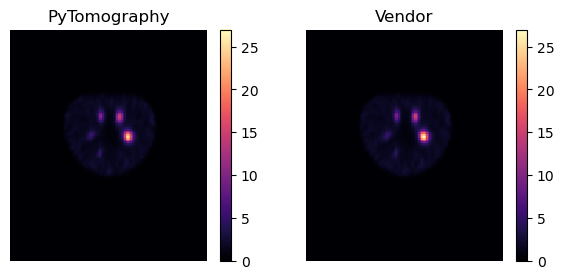

In [21]:
plt.subplots(1,2,figsize=(7,3))
plt.subplot(121)
plt.title('PyTomography')
plt.pcolormesh(slice_pytomography , cmap='magma', vmax=27)
plt.axis('off')
plt.colorbar()
plt.subplot(122)
plt.title('Vendor')
plt.pcolormesh(slice_vendor, cmap='magma', vmax=27)
plt.axis('off')
plt.colorbar()
plt.show()

## Saving Data

PyTomography has functionality for saving DICOM data. There are a few things required:

1. The folder where you want to save the data. The folder can't exist already (has to be a new folder); this prevents overwriting potential data.
2. The reconstructed object itself: in this case, `recon_CTslices`
3. The filepath of the projection data `file_NM`. Much of the study/patient information is copied over from this file to the reconstructed file.
4. An optional string that represents the type of reconstruction performed. If left blank, will be an empty string `''`

**Note: Some vendor reconstructions (i) multiply by the total number of projections and/or (ii) normalize to counts/second when they save their SPECT reconstructions. Make sure to multiply `reconstructed_object` by these values before you save if you want to do such comparisons.**

In [22]:
# Modify the path below to a location on your computer where you want to save the data
save_path = '/disk1/pytomography_tutorial_data/dicom_intro_tutorial/output'
# Code only works if folder doesnt exist, so delete it if present
if os.path.exists(save_path) and os.path.isdir(save_path):
    shutil.rmtree(save_path)
# Save
dicom.save_dcm(
    save_path = save_path,
    object = reconstructed_object,
    file_NM = file_NM,
    recon_name = 'OSEM_4it_8ss')

The data can now be exported to any DICOM viewer of your choice!